# Vision por Computadora I - CEIA

## Trabajo Practico N° 2

#### Autor: Juan Ignacio Ribet

 Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para 
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada 
de Fourier.
1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una 
imagen para validar el funcionamiento en el dominio espectral. 
2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency 
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.
3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of 
focus measure operators in shape-from-focus”

## Tomo como base del trabajo práctico la notebook de Fourier vista en clase.

In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#%matplotlib 

## Filtros en el dominio espectral

In [2]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))
  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv.bitwise_not(lp_filter)

In [3]:
# leo la imagen en escala de grises
img = cv.imread('Material_TP2\\fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
# obtengo el modulo de la transformada de fourier
mod = fft2_mod(img)

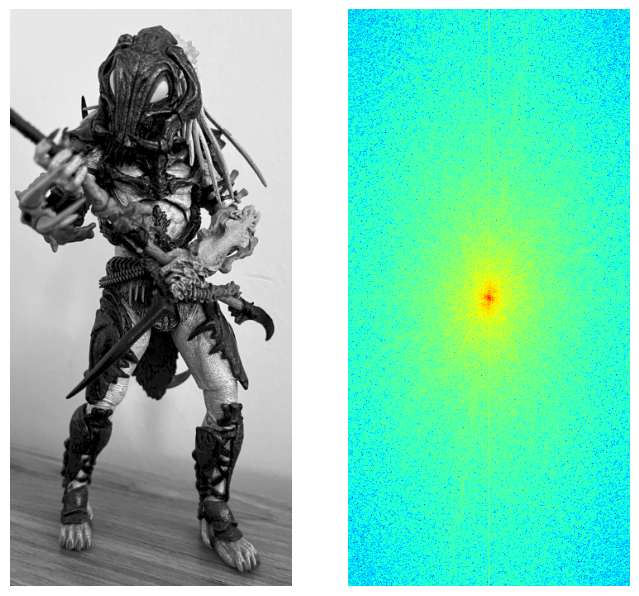

In [4]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

### Definimos los filtros en el dominio espectral

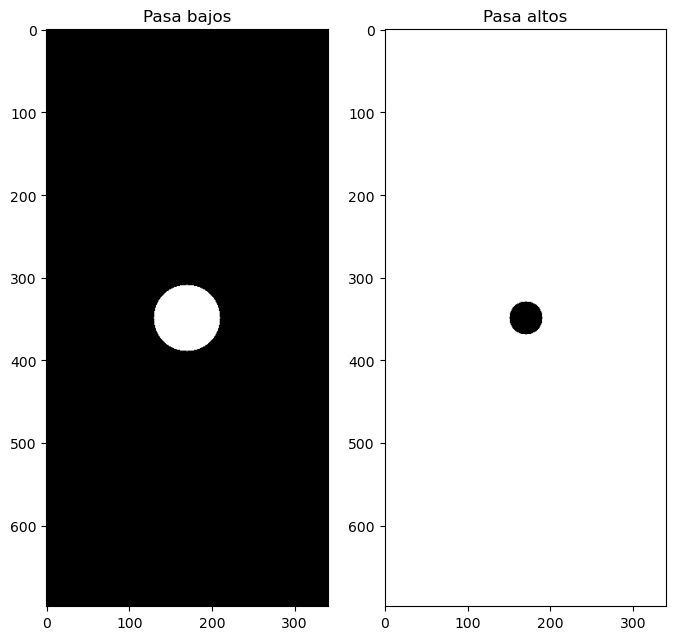

In [5]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

### Aplicamos los filtros a la imagen

In [6]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter
hp_filtered = shifted_fft * hp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))
f_ishift = np.fft.ifftshift(hp_filtered)
img_hp = np.real(np.fft.ifft2(f_ishift))

### Graficamos los resultados

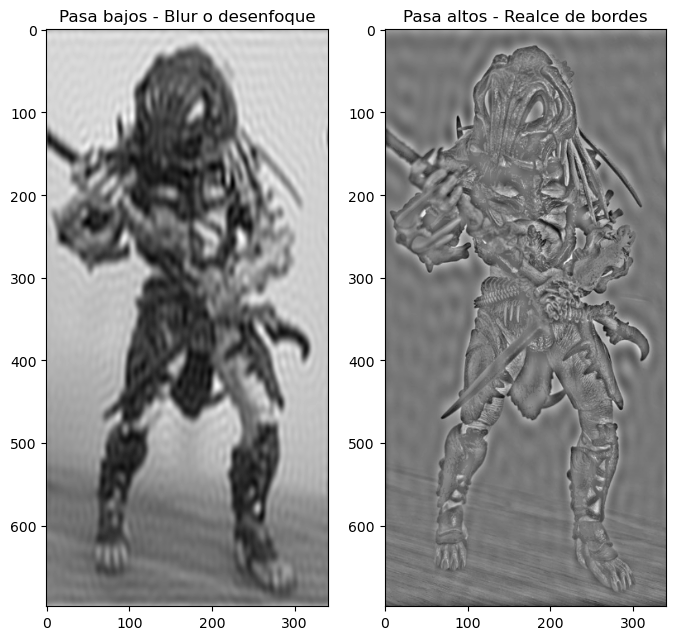

In [7]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')
plt.subplot(1,2,2)
plt.title('Pasa altos - Realce de bordes')
plt.imshow(img_hp, cmap='gray')

 Implementar la función create_gauss_filter(h, w, k_size, sigma) para crear filtros gaussianos para 
filtrado espectral. Debe retornar un filtro gaussiano de tamaño HxW en dominio espacial y su transformada 
de Fourier.

In [8]:
def create_gauss_filter(h, w, k_size=5, sigma=5):

    # Creamos el kernel del filtro Gaussiano
    nucleo_g = cv.getGaussianKernel(ksize=k_size, sigma=sigma) 
    kernel = nucleo_g * nucleo_g.T

    # Creamos el pad para los diferentes shapes del filtro
    bef_aft_h = int(0.5*(h-k_size))
    bef_aft_w = int(0.5*(w-k_size))

    if (h-k_size)%2 == 0 and (w-k_size)%2 == 0:
        kernel = np.pad(kernel, ((bef_aft_h, bef_aft_h), (bef_aft_w, bef_aft_w)), 'constant')
    elif (h-k_size)%2 != 0 and (w-k_size)%2 != 0:
        kernel = np.pad(kernel, ((bef_aft_h, bef_aft_h+1), (bef_aft_w, bef_aft_w+1)), 'constant')
    elif (h-k_size)%2 == 0 and (w-k_size)%2 != 0:
        kernel = np.pad(kernel, ((bef_aft_h, bef_aft_h), (bef_aft_w, bef_aft_w+1)), 'constant')
    elif (h-k_size)%2 != 0 and (w-k_size)%2 == 0:
        kernel = np.pad(kernel, ((bef_aft_h, bef_aft_h+1), (bef_aft_w, bef_aft_w)), 'constant')
    
    # Aplicamos la transformada de Fourier al filtro Gaussiano
    kernel_tf = np.fft.fft2(kernel)

    return kernel, kernel_tf

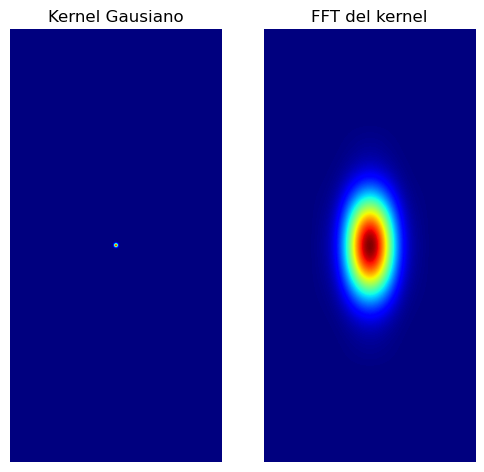

In [9]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=11, sigma=2)

plt.figure(figsize=(6,6))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

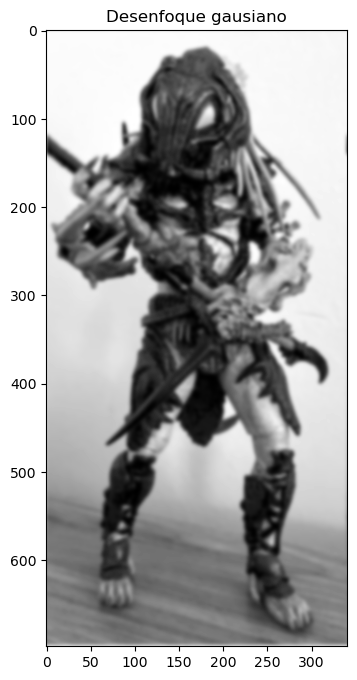

In [10]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

#img_gauss = np.real(np.fft.ifft2(np.fft.ifftshift(filtered)))
img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')

In [11]:
img_gauss.max()

233.43591724914842

1. Graficar ambas representaciones para diferentes tamaños de kernel y sigma. Aplicar el filtro una 
imagen para validar el funcionamiento en el dominio espectral. 

Grafico para tamaños de kernel: 10, 15 y 20 y sigma: 2 y 4


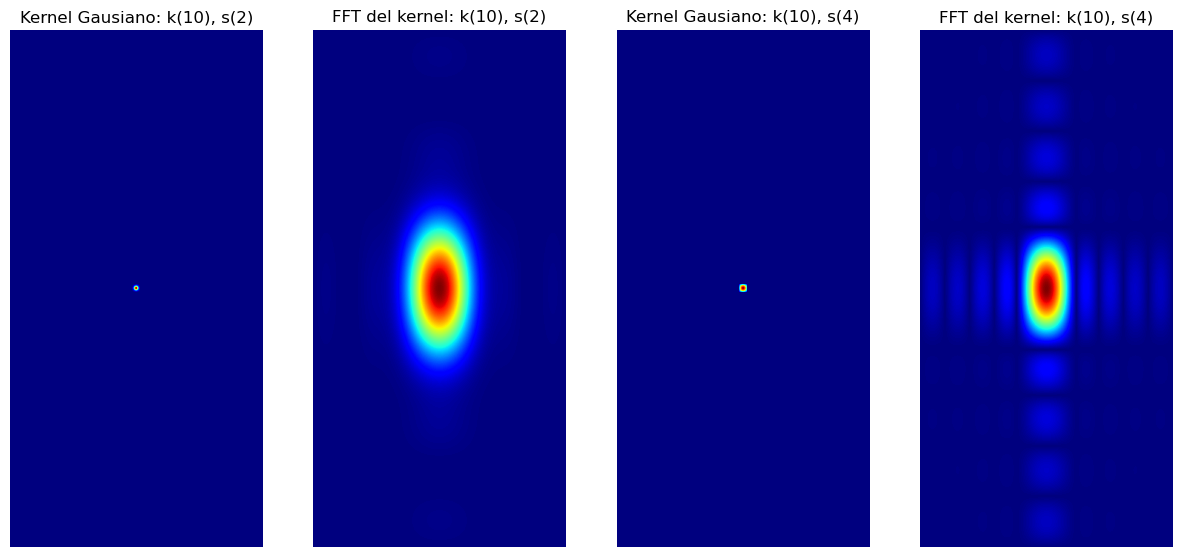

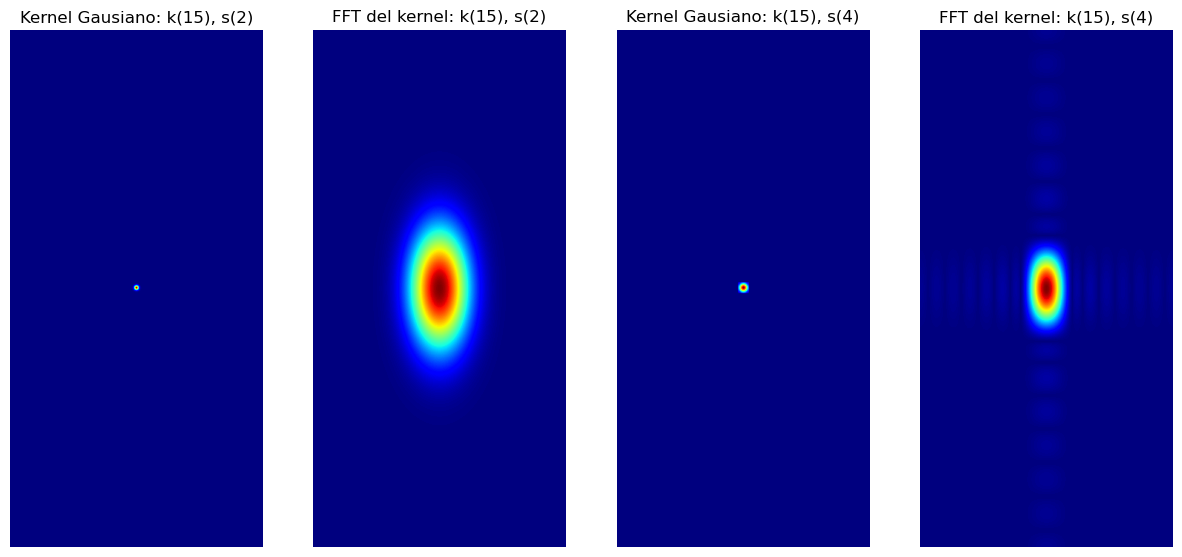

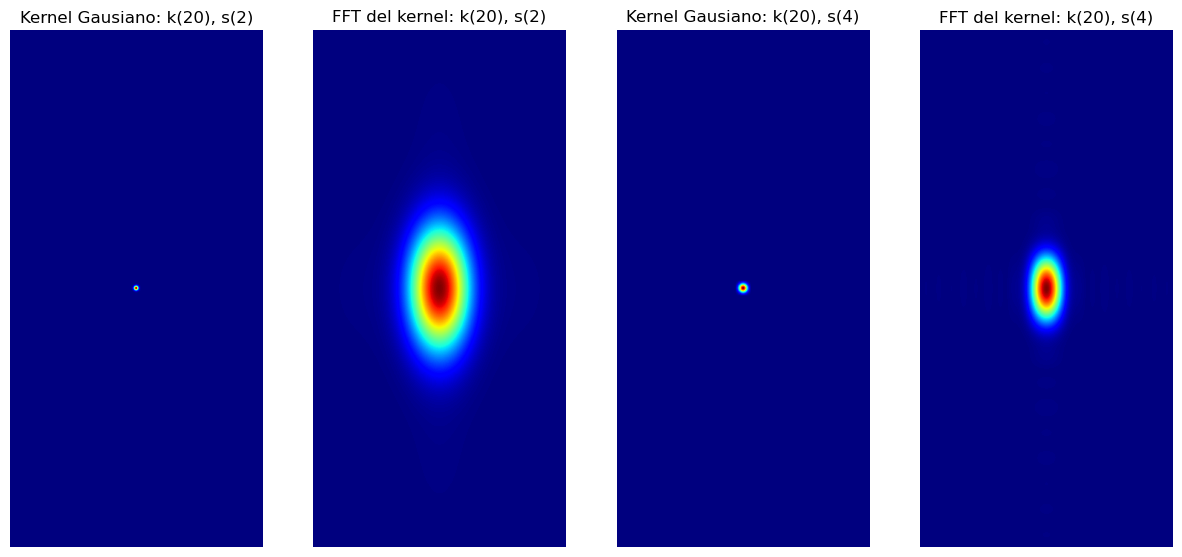

In [12]:
for k in (10,15,20):
    plt.figure(figsize=(15,15))
    for s, i in zip((2,4), (1,3)):
        kernel, kernel_tf = create_gauss_filter(h, w, k_size=k, sigma=s)        
        plt.subplot(1,4,int(i))
        plt.axis('off')
        plt.title(f'Kernel Gausiano: k({k}), s({s})')
        plt.imshow(kernel, cmap='jet')
        plt.subplot(1,4,int(i+1))
        plt.axis('off')
        plt.title(f'FFT del kernel: k({k}), s({s})')
        tf_shifted = np.fft.fftshift(kernel_tf)
        plt.imshow(np.abs(tf_shifted), cmap='jet')


Aplico el filtro a una imagen diferente a la vista en clase:

Text(0.5, 1.0, 'Desenfoque gausiano')

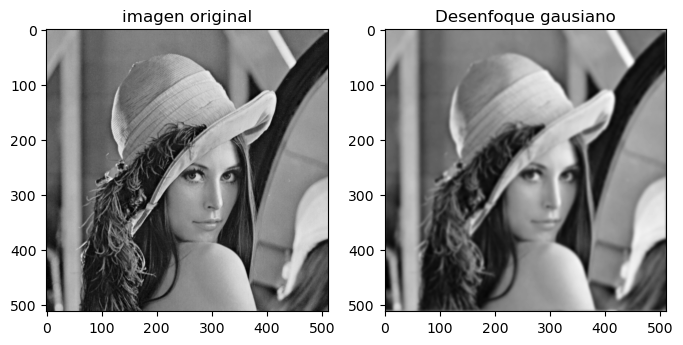

In [13]:
img = cv.imread('Material_TP2\\Lenna.png', cv.IMREAD_GRAYSCALE)

h, w = img.shape
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss_esp = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title('imagen original')
plt.subplot(1,2,2)
plt.imshow(img_gauss_esp, cmap='gray')
plt.title('Desenfoque gausiano')


2. Usando el método descripto en el paper “Image Sharpness Measure for Blurred Images in Frequency 
Domain” comparar el resultado de un filtrado por convolución con el filtrado espectral.

Genero la función 'Freq_Domain_Blur_Measure' siguiendo los pasos indicados en el paper:

In [14]:
    
def Freq_Domain_Blur_Measure(image): # Input: Image I of size M×N. 
     
    # Step 1: Compute F which is the Fourier Transform representation of image I   
    
    F = np.fft.fft2(image)
    
    # Step 2:  Find Fc which is obtained by shifting the origin of F to centre. 

    Fc = np.fft.fftshift(F)
    
    # Step 3: Calculate AF = abs (Fc) where AF is the absolute value of the centered Fourier transform of image I. 

    AF = np.abs(Fc)
    
    # Step 4:  Calculate M = max (AF) where M is the maximum value of the frequency component in F.

    M = np.max(AF)
    
    # Step 5: Calculate TH = the total number of pixels in F whose pixel value > thres, where thres = M/1000. 

    thres = M/1000
    TH = (F > thres).sum()
  
    # Step 6: Calculate Image Quality measure (FM) from equation (TH/M×N). 

    FM = TH / (np.multiply(img.shape[0],img.shape[1]))
    
    # Output: Image Quality measure (FM) where FM stands for Frequency Domain Image Blur Measure 
    
    return FM

In [15]:
print(f'filtrado espectral de imagen Lenna: {Freq_Domain_Blur_Measure(img_gauss_esp)}')

img_gauss_conv =  cv.GaussianBlur(img, ksize=(15, 15), sigmaX=2)

print(f'filtrado convolución de imagen Lenna: {Freq_Domain_Blur_Measure(img_gauss_conv)}')


filtrado espectral de imagen Lenna: 0.002910614013671875
filtrado convolución de imagen Lenna: 0.002964019775390625


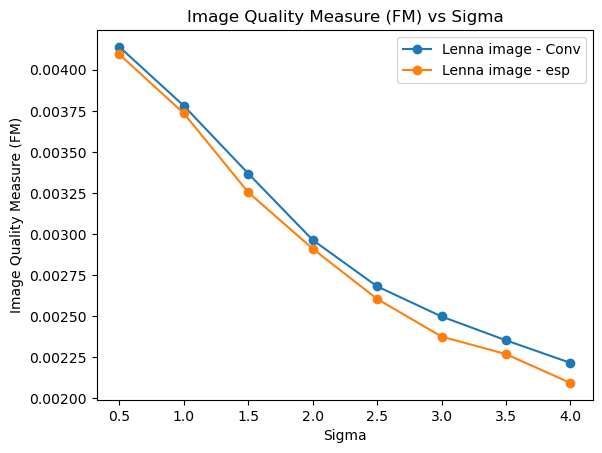

In [16]:
fm_conv = []
fm_esp = []

img_fft = np.fft.fft2(img)

sigma = np.linspace(0.5,4,8)

for i in sigma:

    # filtrado por convolución
    result_a = cv.GaussianBlur(img, ksize=(15, 15), sigmaX=i)
    fm_conv.append(Freq_Domain_Blur_Measure(result_a))

    #filtrado espectral
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=i)
    
    filtered = img_fft * kernel_tf
    result_b = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))
    fm_esp.append(Freq_Domain_Blur_Measure(result_b))

plt.plot(sigma,fm_conv, 'o-')
plt.plot(sigma,fm_esp, 'o-')
plt.xlabel('Sigma')
plt.ylabel('Image Quality Measure (FM)')
plt.title('Image Quality Measure (FM) vs Sigma')
plt.legend(['Lenna image - Conv', 'Lenna image - esp'])

Haciendo la compracion a diferentes valors de sigma se puede ver que la calidad de la imagenes con un filtrado espectral es ligeramente menor que las imagenes con filtrado por convolución.

3. Repetir la comparación usando uno de los métodos descriptos en el apéndice del paper “Analysis of 
focus measure operators in shape-from-focus”

Para este punto vamos a utilizar el apendice A.24 calculando la varianza del nivel de gris de las imagenes.
$$
\Phi_{x,y}  = \sum_{(i,j) \in \Omega_{(x,y)}} (I(ij)-\mu)^2
$$


Donde $\mu$ es la media del nivel de gris de lox pixeles entre $\Omega_{(x,y)}$.

In [17]:
# Gray-level variance (STA3)
# Calculo la metrica con la varianza de la imagen en escala de gris

GLV = int(img.var()) #GLV (Gray-Level Variance)
GLV

2016

In [18]:
img_gauss_esp.dtype

dtype('float64')

In [19]:
GLV_espc = int(img_gauss_esp.var())

GLV_conv = int(img_gauss_conv.var())

print(f'filtrado espectral de imagen Lenna: {GLV_espc}')

print(f'filtrado convolución de imagen Lenna: {GLV_conv}')

filtrado espectral de imagen Lenna: 1797
filtrado convolución de imagen Lenna: 1814


Text(0.5, 1.0, 'filtrado convolución - Gray Level Var = 1814')

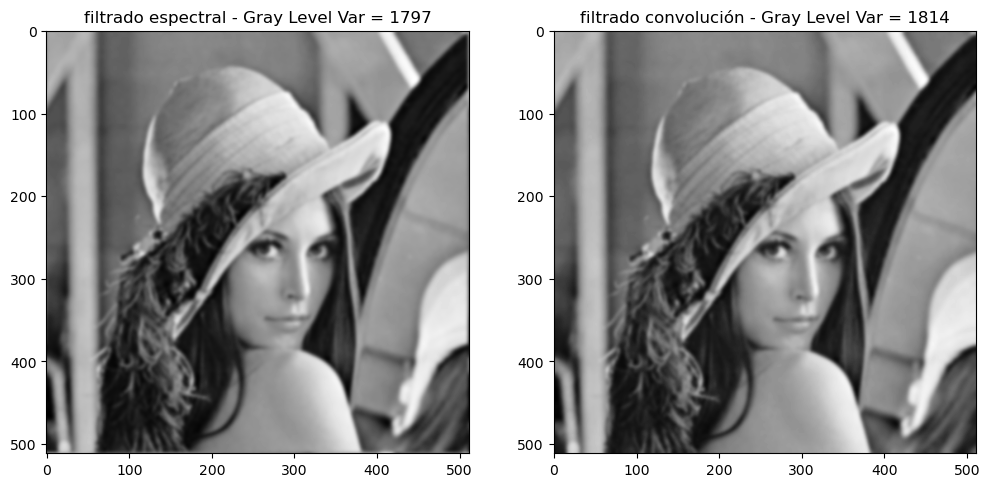

In [20]:
plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.imshow(img_gauss_esp, cmap='gray')
plt.title((f'filtrado espectral - Gray Level Var = {GLV_espc}'))


plt.subplot(1,2,2)
plt.imshow(img_gauss_conv, cmap='gray')
plt.title(f'filtrado convolución - Gray Level Var = {GLV_conv}')

GLV_conv_list : [1987, 1924, 1869, 1814, 1765, 1725, 1695, 1673]
GLV_esp_list : [1983, 1915, 1855, 1797, 1746, 1703, 1670, 1646]


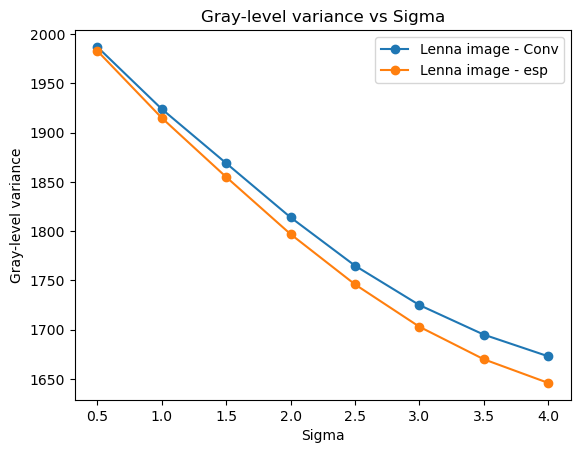

In [21]:
GLV_conv_list = []
GLV_esp_list = []

img_fft = np.fft.fft2(img)
sigma = np.linspace(0.5,4,8)

for i in sigma:

    # filtrado por convolución
    result_a = cv.GaussianBlur(img, ksize=(15, 15), sigmaX=i)
    GLV_conv_list.append(int(result_a.var()))

    # filtrado espectral
    kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=i)
    
    filtered = img_fft * kernel_tf
    result_b = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

    GLV_esp_list.append(int(result_b.var()))
    
plt.plot(sigma,GLV_conv_list, 'o-')
plt.plot(sigma,GLV_esp_list, 'o-')
plt.xlabel('Sigma')
plt.ylabel('Gray-level variance')
plt.title('Gray-level variance vs Sigma')
plt.legend(['Lenna image - Conv', 'Lenna image - esp'])

print('GLV_conv_list :', GLV_conv_list)
print('GLV_esp_list :', GLV_esp_list)

Al igual que en la medida de la calidad de la imagen del punto 2 se puede ver como la variación de los niveles de gris son ligeramente inferiores en la imagen con el filtrado espectral.